### CS 421 PROJECT

In [85]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import random

In [86]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [87]:
# Load the dataset
data = np.load("first_batch_multi_labels.npz")
X = data["X"]
y = data["yy"]

# Create DataFrames
df_X = pd.DataFrame(X, columns=["user", "item", "rating"])
df_y = pd.DataFrame(y, columns=["user", "label"])

def engineer_features(df_X, df_y):
    # Basic user features
    df_user_features = df_X.groupby('user').agg(
        mean_rating=('rating', 'mean'),
        median_rating=('rating', 'median'),
        std_rating=('rating', 'std'),
        count_dislike=('rating', lambda x: (x == -10).sum()),
        count_neutral=('rating', lambda x: (x == 0).sum()),
        count_like=('rating', lambda x: (x == 10).sum()),
        count_watched=('rating', lambda x: (x == 1).sum()),
        total_interactions=('rating', 'count')
    )

    # Ratio features
    df_user_features['like_ratio'] = df_user_features['count_like'] / df_user_features['total_interactions']
    df_user_features['dislike_ratio'] = df_user_features['count_dislike'] / df_user_features['total_interactions']
    df_user_features['neutral_ratio'] = df_user_features['count_neutral'] / df_user_features['total_interactions']
    df_user_features['watched_ratio'] = df_user_features['count_watched'] / df_user_features['total_interactions']
    
    # Interaction patterns
    df_user_features['like_to_dislike_ratio'] = df_user_features['count_like'] / (df_user_features['count_dislike'] + 1)
    df_user_features['rating_variance'] = df_X.groupby('user')['rating'].var()
    
    # Distribution features
    df_user_features['rating_skew'] = df_X.groupby('user')['rating'].apply(lambda x: skew(x))
    df_user_features['rating_kurtosis'] = df_X.groupby('user')['rating'].apply(lambda x: kurtosis(x))
    
    # User behavior patterns
    df_user_features['rating_range'] = df_X.groupby('user')['rating'].apply(lambda x: x.max() - x.min())
    df_user_features['unique_items_ratio'] = df_X.groupby('user')['item'].nunique() / df_user_features['total_interactions']
    
    # Item popularity metrics
    item_popularity = df_X.groupby('item')['rating'].agg(['mean', 'count'])
    item_popularity['popularity_score'] = item_popularity['mean'] * np.log1p(item_popularity['count'])
    
    # Merge item popularity with user interactions
    df_X_with_popularity = pd.merge(df_X, item_popularity['popularity_score'], left_on='item', right_index=True)
    
    # User-item interaction features
    df_user_features['mean_item_popularity'] = df_X_with_popularity.groupby('user')['popularity_score'].mean()
    df_user_features['std_item_popularity'] = df_X_with_popularity.groupby('user')['popularity_score'].std()
    
    # Merge with labels
    df_merged = pd.merge(df_user_features.reset_index(), df_y, on='user')
    
    # Feature selection using mutual information
    X = df_merged.drop(columns=['user', 'label'])
    y = df_merged['label']
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    # Select top 15 features
    top_features = mi_scores.nlargest(15).index.tolist()
    
    # Return the merged dataframe with selected features and label
    return df_merged[['user'] + top_features + ['label']]

# Use the function
df_merged = engineer_features(df_X, df_y)

# Features and Labels
X_features = df_merged.drop(columns=['user', 'label'])
y_labels = df_merged['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=RANDOM_SEED, stratify=y_labels)

# Handling imbalance using SMOTE
smote = SMOTE(random_state=RANDOM_SEED)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Model Training with Random Forest in One-vs-Rest scheme
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, class_weight='balanced')
ovr_model = OneVsRestClassifier(rf_model)

# Use a pipeline for scaling and modeling
pipeline = make_pipeline(StandardScaler(), ovr_model)
pipeline.fit(X_resampled, y_resampled)

# Predictions
y_pred_prob = pipeline.predict_proba(X_test)

# Evaluate with AUC for each class (Normal: class 0, Anomaly 1: class 1, Anomaly 2: class 2)
auc_scores = roc_auc_score(y_test, y_pred_prob, average=None, multi_class='ovr')

# Print the AUC scores for each class
print(f"AUC Scores: Normal (Class 0): {auc_scores[0]:.4f}, Anomaly 1 (Class 1): {auc_scores[1]:.4f}, Anomaly 2 (Class 2): {auc_scores[2]:.4f}")

AUC Scores: Normal (Class 0): 0.9840, Anomaly 1 (Class 1): 0.9876, Anomaly 2 (Class 2): 0.9967


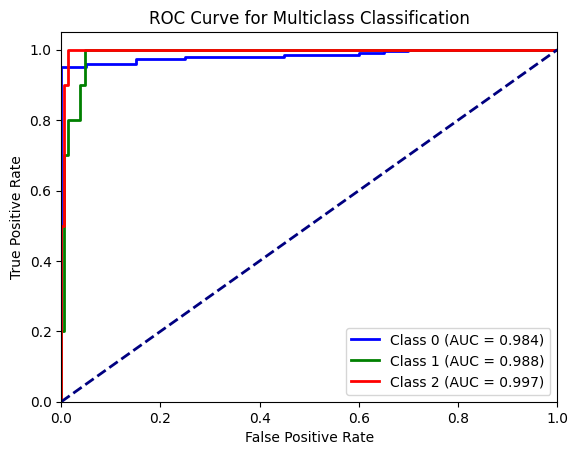

In [88]:
# Binarize the output labels for multiclass ROC curve calculation
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

[[192   7   1]
 [  2   8   0]
 [  1   1   8]]


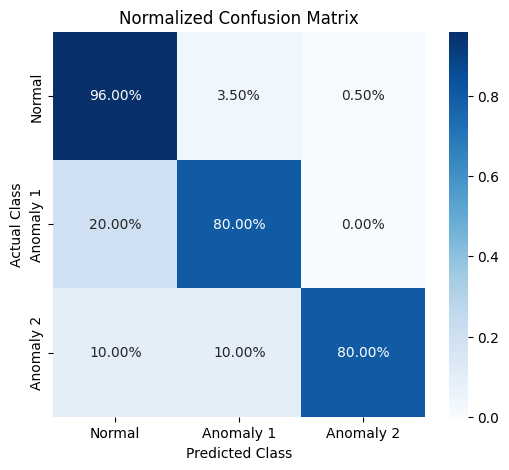

In [89]:
# Make predictions (convert probabilities to class labels)
y_pred = pipeline.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Normalize the confusion matrix by the number of samples in each class
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Display the normalized confusion matrix using Seaborn
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'], 
            yticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'])

plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()